In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml

with open('plfs/perv1.map.yaml', 'r') as fin:
    schema = yaml.safe_load(fin)
df = pd.read_parquet('02-gig-economy/data/gig-economy.parquet')
df.head()

stratum  \
year_quarter sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number           
Q1           urban  20018 1                   1                           02                      04                        01   
                                              2                           01                      03                        01   
                                                                          02                      03                        01   
                                              3                           02                      03                        01   
                                                                                                  05                        01   

                                                                                                                       sub_stratum  \
year_quarter sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number               
Q1           urban  20018 1                   1                           02                      04                            01   
                                              2                           01                      03                            01   
                                                                          02                      03                            01   
                                              3                           02                      03                            01   
                                                                                                  05                            01   

                                                                                                                       sub_sample  \
year_quarter sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number              
Q1           urban  20018 1                   1                           02                      04                            1   
                                              2                           01                      03                            1   
                                                                          02                      03                            1   
                                              3                           02                      03                            1   
                                                                                                  05                            1   

                                                                                                                       fod_sub_region  \
year_quarter sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number                  
Q1           urban  20018 1                   1                           02                      04                             2210   
                                              2                           01                      03                             2210   
                                                                          02                      03                             2210   
                                              3                           02                      03                             2210   
                                                                                                  05                             2210   

                                                                                                                        ns_count_sector_stratum_substratum_subsample  \
year_quarter sector fsu   sample_sg_sb_number second_stage_stratum_number sample_household_number person_serial_number                                                 
Q1           urban  20018 1              

In [2]:
codes = {v: k for k, v in schema['b6q5_perv1']['categories'].items()}

SELF_EMPLOYED = [11, 12, 21, 61, 62]
SALARIED = [31, 71, 72]
CASUAL = [41, 42, 51]
UNEMPLOYED = [81]
df['cws'] = df['current_weekly_status_code'].map(codes).fillna('99').astype(int)
df['wf_status'] = "Not in Workforce"
df.loc[df['cws'].isin(SELF_EMPLOYED), 'wf_status'] = 'Self Employed'
df.loc[df['cws'].isin(SALARIED), 'wf_status'] = 'Salaried'
df.loc[df['cws'].isin(CASUAL), 'wf_status'] = 'Casual Labour'
df.loc[df['cws'].isin(UNEMPLOYED), 'wf_status'] = 'Unemployed'

In [3]:
df['wf_status'].value_counts()

wf_status
Self Employed       5243
Salaried            4083
Casual Labour        327
Not in Workforce     123
Unemployed           101
Name: count, dtype: int64

In [4]:
# broad edu
df.loc[df['general_education'] == 'others', 'general_education'] = "literate without formal schooling: others"
df['broad_edu'] = df['general_education']
df.loc[df['general_education'].str.startswith('literate without formal schooling'), 'broad_edu'] = 'literate without formal schooling'
df['broad_edu'].unique()

array(['secondary', 'middle', 'higher secondary',
       'diploma/certificate course', 'graduate', 'not literate',
       'primary', 'below primary', 'literate without formal schooling'],
      dtype=object)

In [5]:
educat = pd.CategoricalDtype(
    ['not literate', 'literate without formal schooling', 'below primary',
     'primary', 'secondary', 'middle', 'higher secondary', 'diploma/certificate course',
     'graduate', 'postgraduate and above'],
ordered=True)
df['broad_edu'] = df['broad_edu'].astype(educat)

In [6]:
# income
male = df[df['gender'] == 'male']
female = df[df['gender'] == 'female']

male_salaried = male[male['wf_status'] == 'Salaried'].groupby('broad_edu')['weekly_salaried_earnings'].mean()
male_selfemp = male[male['wf_status'] == 'Self Employed'].groupby('broad_edu')['weekly_self_employed_earnings'].mean()
male_casual = male[male['wf_status'] == 'Casual Labour'].groupby('broad_edu').apply(lambda x: x[[c for c in x if c.startswith('wage_earned_')]].sum(axis=1).mean() * 4)
pdf_income_male = pd.concat([male_casual, male_salaried, male_selfemp], axis=1)
pdf_income_male.columns = ['Casual Labour', 'Salaried', 'Self Employed']
pdf_income_male = pdf_income_male.iloc[:-1]

female_salaried = female[female['wf_status'] == 'Salaried'].groupby('broad_edu')['weekly_salaried_earnings'].mean()
female_selfemp = female[female['wf_status'] == 'Self Employed'].groupby('broad_edu')['weekly_self_employed_earnings'].mean()
female_casual = female[female['wf_status'] == 'Casual Labour'].groupby('broad_edu').apply(lambda x: x[[c for c in x if c.startswith('wage_earned_')]].sum(axis=1).mean() * 4)
pdf_income_female = pd.concat([female_casual, female_salaried, female_selfemp], axis=1)
pdf_income_female.columns = ['Casual Labour', 'Salaried', 'Self Employed']
pdf_income_female = pdf_income_female.iloc[:-1]

/tmp/ipykernel_38765/924841614.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  male_salaried = male[male['wf_status'] == 'Salaried'].groupby('broad_edu')['weekly_salaried_earnings'].mean()
/tmp/ipykernel_38765/924841614.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  male_selfemp = male[male['wf_status'] == 'Self Employed'].groupby('broad_edu')['weekly_self_employed_earnings'].mean()
/tmp/ipykernel_38765/924841614.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

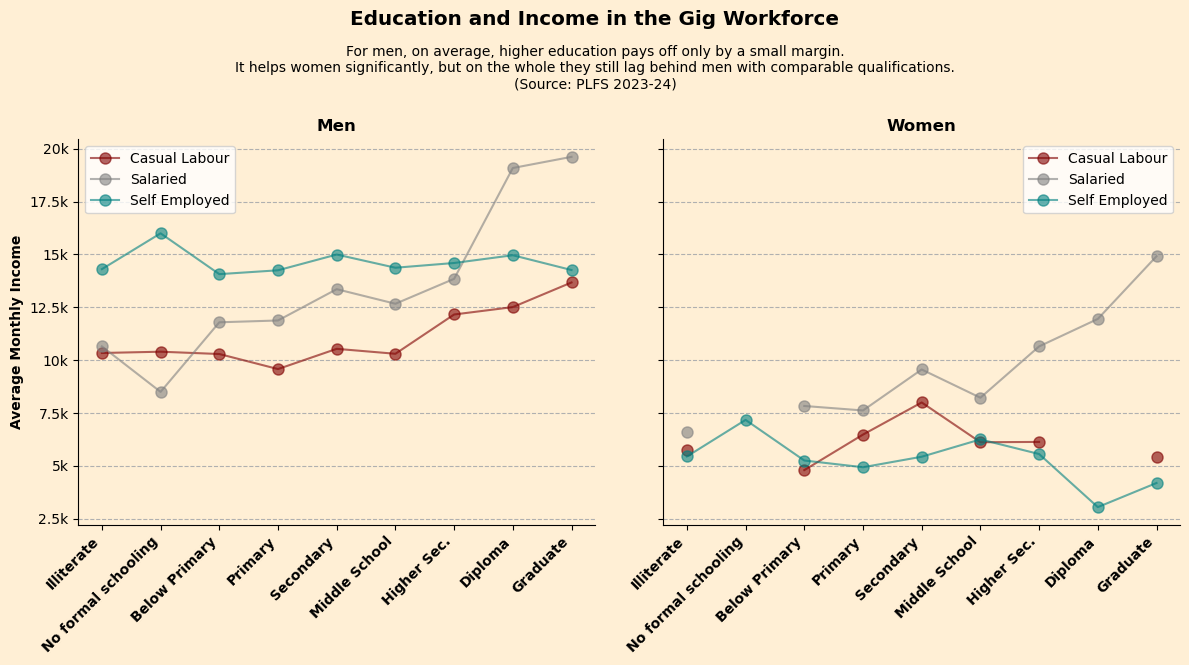

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))
labels = ['Illiterate', 'No formal schooling', 'Below Primary', 'Primary', 'Secondary', 'Middle School', 'Higher Sec.', 'Diploma', 'Graduate']
COLORS = {'Casual Labour': 'maroon', 'Self Employed': 'teal', 'Salaried': 'grey'}
for col in pdf_income_male:
    ax[0].plot(range(len(pdf_income_male)), pdf_income_male[col], '-o', label=col, alpha=0.6, color=COLORS[col], markersize=8)
    ax[1].plot(range(len(pdf_income_female)), pdf_income_female[col], '-o', label=col, alpha=0.6, color=COLORS[col], markersize=8)
ax[0].set_xticks(range(len(pdf_income_male)), labels, rotation=45, ha='right', fontfamily='DejaVu Sans', fontweight='bold')
ax[1].set_xticks(range(len(pdf_income_female)), labels, rotation=45, ha='right', fontfamily='DejaVu Sans', fontweight='bold')
ax[0].set_title('Men', fontweight='bold', fontfamily='DejaVu Sans')
ax[1].set_title('Women', fontweight='bold', fontfamily='DejaVu Sans')
ax[0].set_yticks([k * 100 for k in range(25, 201, 25)])
ax[0].set_yticklabels([f"{c}k" for c in [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]], fontfamily='DejaVu Sans')
ax[0].set_ylabel('Average Monthly Income', fontfamily='DejaVu Sans', fontweight='bold')

ax[0].legend()
ax[1].legend()
fig.patch.set_facecolor('papayawhip')
[a.set_facecolor('papayawhip') for a in ax.ravel()]
[a.grid(axis='y', linestyle='dashed') for a in ax.ravel()]
for a in ax.ravel():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

fig.suptitle('Education and Income in the Gig Workforce', fontsize='x-large', fontweight='bold', fontfamily='DejaVu Sans', y=1.1)
fig.text(0.5, 0.97, 'For men, on average, higher education pays off only by a small margin.\nIt helps women significantly, but on the whole they still lag behind men with comparable qualifications.\n(Source: PLFS 2023-24)', fontsize='medium', ha='center', fontfamily='DejaVu Sans')
plt.tight_layout()

In [42]:
list(range(25, 201, 25))

[25, 50, 75, 100, 125, 150, 175, 200]

In [84]:
edu_necessary = df['current_attendance_educational_inst'].isin(['03', '13'])

In [86]:
df['edu_necessary'] = edu_necessary

In [88]:
xx = df[df['wf_status'] == 'Salaried']
xx.groupby('edu_necessary')['weekly_salaried_earnings'].mean()

edu_necessary
False    13885.780247
True     10360.606061
Name: weekly_salaried_earnings, dtype: float64

In [89]:
xx = df[df['wf_status'] == 'Self Employed']
xx.groupby('edu_necessary')['weekly_self_employed_earnings'].mean()

edu_necessary
False    13018.243550
True      6002.040816
Name: weekly_self_employed_earnings, dtype: float64

<AxesSubplot:xlabel='n_years_formal_education'>

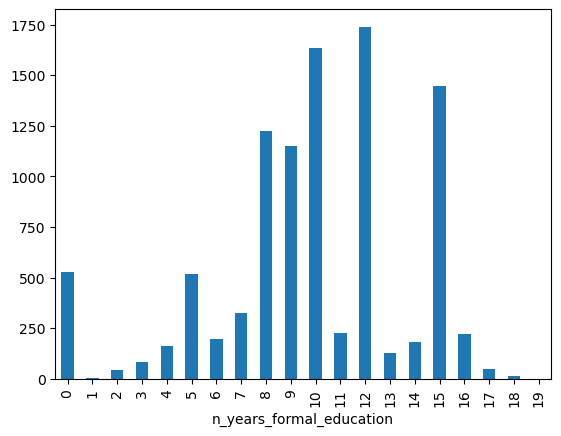

In [95]:
df['n_years_formal_education'].value_counts().sort_index().plot(kind='bar')

In [96]:
xx['current_attendance_educational_inst'].value_counts()

current_attendance_educational_inst
      3861
12    1052
15     159
14      51
13      49
31      31
05      10
02      10
27       7
32       6
29       3
34       1
37       1
26       1
04       1
Name: count, dtype: int64